In [67]:
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm, AnovaRM

### Тесты
1) **ANOVA** – тест, предназначенный для сравнения средних значений между группами. Может сравнивать различие по одной категорной переменной, по паре, по их взаимодействию, а также с учётом зависимых измерений. Требует нормальности остатков, гомогенности дисперсий, а также достаточно большого количества.
2) **Тест Тьюки** определяет, состоит ли ваша выборка из групп, которые отличаются друг от друга. Каждое среднее сравнивается со средним всех других групп с помощью "Честной значимой разницы", которая показывает, насколько далеко друг от друга находятся группы. Нередко используется для анализа результатов, полученных с помощью ANOVA (можно проверять предположения, сделанные на основе визуального анализа – что среднее одной группы превосходит среднее по всем остальным).


# Задача 1. Сравнение эффективности программ подготовки к экзаменам.
Предположим, что мы хотим узнать, одинаковы ли по эффективности три разных программ подготовки к экзаменам. Ниже приведена таблица с оценками студентов, обучавшихся по соответственным программам.

![(Таблица)](hw3_task1_table.png)

Проведите анализ того, различаются ли программы по эффективности и
предположите, какая из них наилучшая/наихудшая. Оба пункта следует
подкрепить соответствующими методами.

## Решение

Для данной задачи подходит _тест Тьюки_ так как он позволяет определить насколько группы различны.

In [2]:
data = pd.read_csv("Task1_data.csv")
data

,group 1,group 2,group 3
0,85,91,79
1,86,92,78
2,88,93,88
3,75,85,94
4,78,87,92
5,94,84,85
6,98,82,83
7,79,88,85
8,71,95,82
9,80,96,81


In [3]:
res = st.tukey_hsd(*data.to_numpy().T)
groups = ['Group 1', 'Group 2', 'Group 3']
pd.DataFrame(res.pvalue, columns=groups, index=groups)

,Group 1,Group 2,Group 3
Group 1,1.000000,0.115991,0.892477
Group 2,0.115991,1.000000,0.258352
Group 3,0.892477,0.258352,1.000000


$H_0$ - группы не различны. В данном случае мы не можем отвергнуть эту гипотезу ни для одной пары групп. Следовательно, группы примерно одинаковы в плане эффективности.

Посмотрим на значение статистики:

In [4]:
pd.DataFrame(res.statistic, columns=groups, index=groups)

,Group 1,Group 2,Group 3
Group 1,0.0,-5.9,-1.3
Group 2,5.9,0.0,4.6
Group 3,1.3,-4.6,0.0


Группа 2 имеет наивысшее среднее из всех значений статистики, но невозможно однозначно называть её лучшей - поскольку ранее заключили, что эффективностью она не отличается от остальных групп.

Посмотрим на график:

<Axes: >

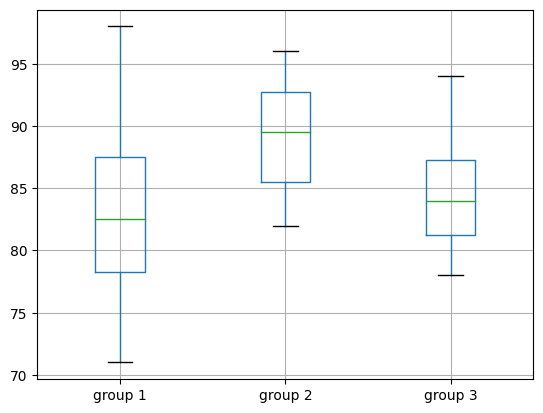

In [5]:
data.boxplot()

На графике мы видим подтверждение нашему заключению. Среднее группы 2 сильно выше чем среднее других групп, но мы не можем с уверенностью назвать её лучше поскольку максимальное значение принадлежит группе 1.

# Задача 2. Сравнение эффективности стратегий выращивания растений

Было проведено исследование эффективности различных стратегий посева. В исследовании участвовали две категорные переменные: используемое удобрение и плотность посадки. Выяснить, есть ли различие между разными вариантами взращивания, а также провести post-hoc анализ на основе визуализации результатов, который позволит выяснить, как соотносится эффективность стратегий. Оба пункта подкрепить соответствующими тестами.

Данные находятся в файле [Task2_data.csv](Task2_data.csv)

## Решение

У нас есть целевая аудитория - урожайность (`yield`) и 2 категориальные переменные - используемое удобрение (`fertilizer`) и плотность посадки (`density`). Зависимых переменных нет. В данной ситуации мы можем использовать тест _Anova_ (two-way), но сначала проверим есть ли у нас пререквизиты для неё:
 * Нужно нормальное распределение остатков модели
 * Нужна гомогенность дисперсии между группами

In [6]:
data = pd.read_csv("Task2_data.csv")
data = data.drop(columns="block").rename(columns={'yield': 'yield_data'})
data

,density,fertilizer,yield_data
0,1,1,177.228692
1,2,1,177.550041
2,1,1,176.408462
3,2,1,177.703625
4,1,1,177.125486
...,...,...,...
91,2,3,177.405292
92,1,3,178.141644
93,2,3,177.710613
94,1,3,177.687264


In [7]:
formula = "yield_data ~ C(density) + C(fertilizer) + C(density):C(fertilizer)"
model = ols(formula, data).fit()

Посмотрим на остатки

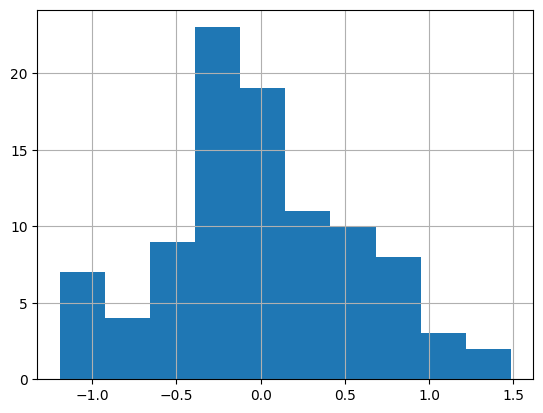

In [8]:
model.resid.hist()
plt.show()

Из далека выглядит как совсем чуть-чуть скошенное нормальное распределение. Дополнительно проверим тестом Шапиро.



In [9]:
p_val: float = st.shapiro(model.resid).pvalue
print(f"Shapiro p-value: {p_val*100:.2f}%")

Shapiro p-value: 36.01%


Мы не можем отвергнуть гипотезу о том, что остатки распределены нормально. Теперь проеврим гомогенность дисперсий.

In [10]:
dens: str = "density"
fert: str = "fertilizer"

groups = []
for x in data[dens].unique():
    for y in data[fert].unique():
        gr1 = data[data[dens] == x]
        groups.append(gr1[gr1[fert] == y]["yield_data"])

p_val = st.levene(*groups).pvalue
print(f"Levene p-value: {p_val*100:.2f}%")

Levene p-value: 97.68%


Гипотеза о гомогенности дисперсий не может быть отвергнута.

Мы не смогли отвергнуть гипотезы о нормальном распределении остатков и гомогенности дисперсий и можем с относительно большой уверенностью использовать _Anova_.

In [11]:
anova_table = anova_lm(model, typ=2)  # two-way Anova
anova_table

,sum_sq,df,F,PR(>F)
C(density),5.121681,1.0,15.194517,0.000186
C(fertilizer),6.068047,2.0,9.001052,0.000273
C(density):C(fertilizer),0.427818,2.0,0.634605,0.532500
Residual,30.336687,90.0,NaN,NaN


Для плотности и удобрения отклоним нулевую гипотезу о том, что разница между группами незначительна. При этом мы не можем отклонить нулевую гипотезу о том, что взаимодействие факторов незначительно.

Визуализируем группы.

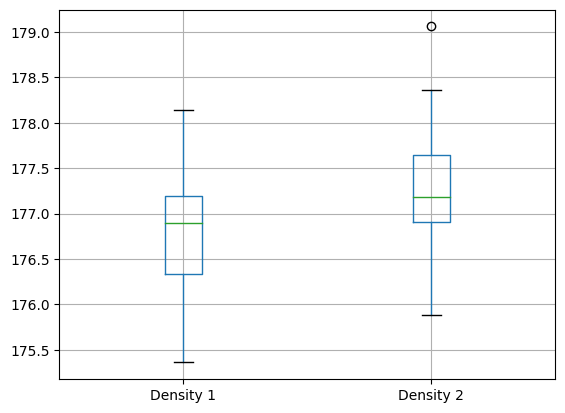

In [12]:
yld = data["yield_data"]
gr_dens = pd.DataFrame()
for f in data[dens].unique():
    gr = yld[data[dens] == f].reset_index(drop=True)
    gr_dens[f"Density {f}"] = gr

gr_dens.boxplot()
plt.show()

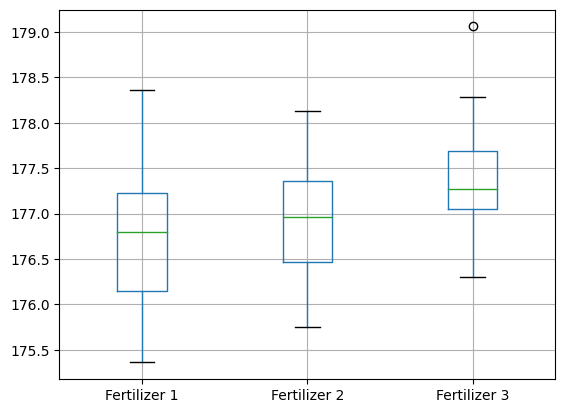

In [13]:
gr_fert = pd.DataFrame()
for f in data[fert].unique():
    gr = yld[data[fert] == f].reset_index(drop=True)
    gr_fert[f"Fertilizer {f}"] = gr

gr_fert.boxplot()
plt.show()

Визуально мы модем сказать, что плотность 2 и удобрение 3 дают лучший результат в своих категориях. Сравним их с помощью теста Тьюки.

In [14]:
def cute_table(matrix: np.ndarray, names: list[str]):
    return pd.DataFrame(matrix, columns=names, index=names)

def cute_tukey(df: pd.DataFrame):
    res = st.tukey_hsd(*df.to_numpy().T)
    print('p-value:')
    print(cute_table(res.pvalue, df.columns))
    print('Statistic:')
    print(cute_table(res.statistic, df.columns))

In [15]:
print("Density")
cute_tukey(gr_dens)

Density
p-value:
           Density 1  Density 2
Density 1   1.000000   0.000485
Density 2   0.000485   1.000000
Statistic:
           Density 1  Density 2
Density 1   0.000000  -0.461956
Density 2   0.461956   0.000000


**Для плотности**: Нулевая гипотеза о том, что группы неразличны отклонена из-за низкого p-value, что подтверждает визуальные наблюдения, статистика подтверждает большее среднее у группы 2.

In [16]:
print("Fertilizer")
cute_tukey(gr_fert)

Fertilizer
p-value:
              Fertilizer 1  Fertilizer 2  Fertilizer 3
Fertilizer 1      1.000000      0.495471      0.000612
Fertilizer 2      0.495471      1.000000      0.020873
Fertilizer 3      0.000612      0.020873      1.000000
Statistic:
              Fertilizer 1  Fertilizer 2  Fertilizer 3
Fertilizer 1      0.000000     -0.176169     -0.599126
Fertilizer 2      0.176169      0.000000     -0.422957
Fertilizer 3      0.599126      0.422957      0.000000


**Для удобрения**: Мы не можем отклонить гипотезу о том, что группы 1 и 2 различны и не можем отклонить эту гипотезу для групп 2 и 3 при $\alpha = 0.01$ (но можем отклонить при $\alpha = 0.05$)

Тогда с уверенностью мы можем сказать, что лишь группы 1 и 3 сильно различаются, при этом группа 3 даёт лучшие результаты.

# Задача 3. Оценка эффективности программы тренировок.

Предположим, что мы хотим узнать, оказывает ли эффект программа
тренировок на пульс в покое у тех, кто её проходит. Мы отслеживали данный
параметр у 5 людей в течение 8 месяцев и результаты получились
следующие:

![(Table)](hw3_task3_table.png)

Проведите анализ того, оказывает ли программа эффект на ЧСС в покое.
Анализ должен быть подкреплён одним соответствующим тестом.


## Решение

Данные зависимы поэтому воспользуемся Anova с коррекцией для данных с повторными измерениями.

Сначала посмотрим визуально.


In [61]:
office_data = pd.read_csv("Task3_data.csv", index_col=0)
office_data

,Before,4 Month,8 Month
Subject,,,
Michael,65,58,60
Dwight,55,48,44
Andy,58,55,55
Meredith,68,60,55
Angela,47,45,45


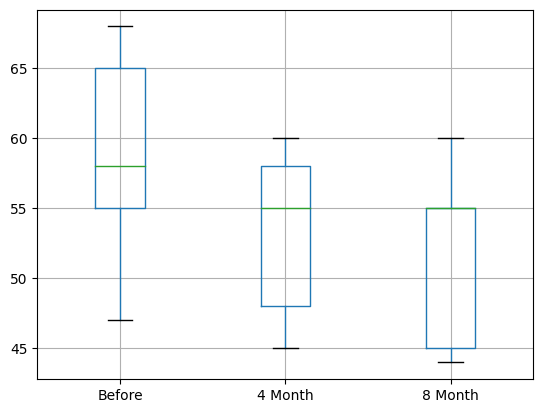

In [83]:
office_data.boxplot()
plt.show()

Визуально разница в разбросе значений очень заметна, но в то же время видно, что средние значения не сильно меняются.

Данные зависимы поэтому для использования нулевой гипотезы нужно использовать ANOVA с коррекцией для повторных измерений.
Изменим формат данных, чтобы их можно было передать в AnovaRM


In [64]:
subjects = office_data.index
office_table = pd.DataFrame({
    "Subject": np.repeat(subjects, 3),
    "Duration": np.tile([0, 4, 8], len(subjects)),
    "Heart Rate": office_data.to_numpy().reshape(-1)  # flatten all data
})
office_table

,Subject,Duration,Heart Rate
0,Michael,0,65
1,Michael,4,58
2,Michael,8,60
3,Dwight,0,55
4,Dwight,4,48
5,Dwight,8,44
6,Andy,0,58
7,Andy,4,55
8,Andy,8,55
9,Meredith,0,68


Построим модель ANOVA

In [75]:
res = AnovaRM(data=office_table, depvar='Heart Rate', subject='Subject', within=['Duration']).fit()
res.anova_table

,F Value,Num DF,Den DF,Pr > F
Duration,9.598015,2.0,8.0,0.007488


Получили p-value = 0.007488, поэтому отвергаем нулевую гипотезу о том, что длительность участия никак не влияет на сердцебиение.
Посмотрим на график

In [18]:
# Old Tukey test
cute_tukey(office_data)

p-value:
            Before   4 Month   8 Month
 Before   1.000000  0.492047  0.337121
 4 Month  0.492047  1.000000  0.950731
 8 Month  0.337121  0.950731  1.000000
Statistic:
           Before   4 Month   8 Month
 Before       0.0       5.4       6.8
 4 Month     -5.4       0.0       1.4
 8 Month     -6.8      -1.4       0.0


По итогам теста Тьюки мы не можем отвергнуть нулевую гипотезу о том, что группы неразличны ни для одной пары групп.
Но результаты этого теста неприменимы к этим данным.